In [72]:
import os
import re
import string
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

BATCH_SIZE = 32
EPOCHS = 5
MAX_LEN = 75
EMBEDDING = 50

def isEven(n):
    return n % 2 == 0

def filter_string(s):
    return ''.join(filter(lambda x: x in string.printable, s))

def split_words(s):
    return re.sub("[^\w]", " ",  s).split()

def transform_sentences(sentences):
    # Convert each sentence from list of Token to list of word_index
    X = [[word2idx[w[0]] for w in s] for s in sentences]
    # Padding each sentence to have the same lenght
    X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

    # Convert Tag/Label to tag_index
    y = [[tag2idx[w[1]] for w in s] for s in sentences]
    # Padding each sentence to have the same lenght
    y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

    # One-Hot encode
    y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)
    return X, y


In [73]:
leis_dir = 'leis_vetadas/'
leis = []
leis_split = []
words = []
for fname in os.listdir(leis_dir):
    with open(leis_dir+fname, "r", encoding="utf-8") as f:
        r = f.read()
        leis.append(r)
        leis_split.append(r.split('**VETO**'))
        file_words = text_to_word_sequence(r)
        # file_words = split_words(r)
        words += file_words


In [74]:
#X_tmp = []
#y_tmp = []
sentences = []

for l in leis_split:
    i = 0
    sx = []
    sy = []
    for s in l:
        i += 1
        w = text_to_word_sequence(s)
        sx += w
        if isEven(i):
            sy += ["b-veto"]
            sy += ["veto" for _ in range(len(w)-2)]
            sy += ["e-veto"]
        else:
            sy += ['b-ok']
            sy += ["ok" for _ in range(len(w)-2)]
            sy += ['e-ok']
    sentences.append([[sx[a],sy[a]] for a in range(len(w))])

# sentences = list(zip(X_tmp, y_tmp))

In [87]:
vocab = list(set(words))
n_words = len(vocab)

tags = ["ok",'b-ok','e-ok',"veto",'b-veto','e-veto']
n_tags = len(tags)

word2idx = {w: i + 2 for i, w in enumerate(vocab)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word paulo is identified by the index: {}".format(word2idx["paulo"]))
print("ok {}".format(tag2idx["ok"]))

X, y = transform_sentences(sentences)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[1] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])
# print(idx2tag)

The word paulo is identified by the index: 3747
ok 1
Raw Sample:  projeto de lei nº 283 de 2012 institui a semana de conscientização prevenção e combate a verminose no estado de são paulo e dá outras providências a assembleia legislativa do estado de são paulo decreta artigo 1º fica a secretaria estadual de saúde autorizada instituir a semana de conscientização prevenção e combate a verminose no estado de são paulo parágrafo único a semana de conscientização prevenção e combate a verminose no estado são paulo mencionada no caput deste artigo deverá obrigatoriamente abranger a primeira semana de abril artigo 2º os objetivos da semana de conscientização prevenção e combate a verminose no estado de são paulo i promover a conscientização e orientar com regras básicas de cuidados de higiene domiciliar e pessoal para evitar a contaminação através de profissionais qualificados ii criar a oportunidade de integração de órgãos e entidades públicos e privados em ações conjuntas em benefício da co

In [93]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
#from keras.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.15))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

model.load_weights("model/alesp-2019-05-24.hdf5")

/usr/lib64/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/lib64/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 75, 50)            228000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 75, 100)           40400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_3 (CRF)                  (None, 75, 7)             420       
Total params: 273,870
Trainable params: 273,870
Non-trainable params: 0
_________________________________________________________________


In [88]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=400,
                    validation_split=0.1, verbose=2)

Train on 18 samples, validate on 2 samples
Epoch 1/400
 - 0s - loss: 1.6767 - crf_viterbi_accuracy: 0.9666 - val_loss: -3.4180e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 2/400
 - 0s - loss: 1.3040 - crf_viterbi_accuracy: 0.9837 - val_loss: 1.9531e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 3/400
 - 0s - loss: 1.1841 - crf_viterbi_accuracy: 1.0000 - val_loss: -3.4180e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 4/400
 - 0s - loss: 1.1837 - crf_viterbi_accuracy: 1.0000 - val_loss: -1.9531e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 5/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -9.7656e-06 - val_crf_viterbi_accuracy: 1.0000
Epoch 6/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -8.1380e-06 - val_crf_viterbi_accuracy: 1.0000
Epoch 7/400
 - 0s - loss: 1.1836 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.4414e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 8/400
 - 0s - loss: 1.1836 - crf_viterbi_accuracy: 1.0000 - val_loss: 1.6276e-06 - val_crf_v

 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 6.5104e-06 - val_crf_viterbi_accuracy: 1.0000
Epoch 68/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 8.1380e-06 - val_crf_viterbi_accuracy: 1.0000
Epoch 69/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 1.3021e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 70/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.8828e-06 - val_crf_viterbi_accuracy: 1.0000
Epoch 71/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.8828e-06 - val_crf_viterbi_accuracy: 1.0000
Epoch 72/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -2.9297e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 73/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -2.6042e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 74/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -9.7656e-06 - val_crf_viterbi_accuracy: 1.0000
Epoch 75/400
 - 0s - loss:

Epoch 134/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -2.1159e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 135/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -1.9531e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 136/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_crf_viterbi_accuracy: 1.0000
Epoch 137/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -3.7435e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 138/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -2.2786e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 139/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -1.9531e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 140/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 3.2552e-06 - val_crf_viterbi_accuracy: 1.0000
Epoch 141/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -2.2786e-05 - val_crf_viterbi_accuracy: 1.0000
Ep

Epoch 200/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -2.1159e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 201/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -9.7656e-06 - val_crf_viterbi_accuracy: 1.0000
Epoch 202/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -2.2786e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 203/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -2.4414e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 204/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 1.6276e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 205/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.4414e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 206/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -2.2786e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 207/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -1.7904e-05 - val_crf_viterbi_accuracy: 1.0000
Ep

Epoch 266/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 1.4648e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 267/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -3.4180e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 268/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 1.6276e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 269/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 1.4648e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 270/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -2.4414e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 271/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 4.8828e-06 - val_crf_viterbi_accuracy: 1.0000
Epoch 272/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 8.1380e-06 - val_crf_viterbi_accuracy: 1.0000
Epoch 273/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -2.4414e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch

Epoch 332/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.9297e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 333/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -4.0690e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 334/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -3.9062e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 335/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -2.2786e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 336/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -1.1393e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 337/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 8.1380e-06 - val_crf_viterbi_accuracy: 1.0000
Epoch 338/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -2.6042e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 339/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -6.5104e-06 - val_crf_viterbi_accuracy: 1.0000
Ep

Epoch 398/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -3.0924e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 399/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: 2.1159e-05 - val_crf_viterbi_accuracy: 1.0000
Epoch 400/400
 - 0s - loss: 1.1834 - crf_viterbi_accuracy: 1.0000 - val_loss: -1.6276e-06 - val_crf_viterbi_accuracy: 1.0000


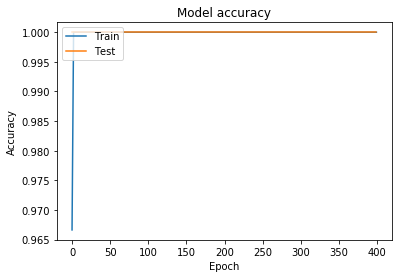

In [89]:
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

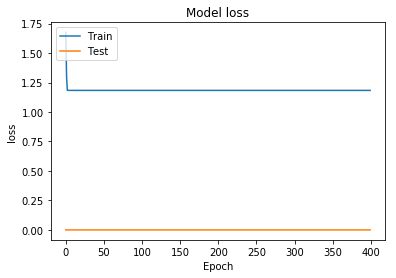

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [91]:
# Eval
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)

print(report)

              precision    recall  f1-score   support

         PAD       1.00      1.00      1.00        54
        b-ok       1.00      1.00      1.00         1
        e-ok       1.00      1.00      1.00         1
          ok       1.00      1.00      1.00       169

   micro avg       1.00      1.00      1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225



In [81]:
from ipywidgets import interact_manual
from ipywidgets import widgets

import sys
import math
import re
import string

# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
    
def get_prediction(sentence):
    test_sentence = tokenize(sentence) # Tokenization
    s_len = len(test_sentence)
    #print('len(test_sentence)', s_len)
    # Preprocessing
    for step in range(math.ceil(s_len / MAX_LEN)):
        sentence1 = test_sentence[75*step:75*(step+1)]
        #print(sentence1)
        x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in sentence1]],
                                padding="post", value=word2idx["PAD"], maxlen=MAX_LEN)
        # Evaluation
        #print(x_test_sent)
        p = model.predict(np.array([x_test_sent[0]]))
        p = np.argmax(p, axis=-1)
        # Visualization
        #print("{:15}||{}".format("Word", "Prediction"))
        #print(30 * "=")
        for w, pred in zip(test_sentence, p[0]):
            #print("{:15}: {:5}".format(w, idx2tag[pred]))
            if idx2tag[pred] in ['b-veto', 'veto', 'e-veto']:
                sys.stdout.write("\x1b[31m"+w+"\x1b[0m ")
            else:
                sys.stdout.write(w+' ')

interact_manual(get_prediction, sentence=widgets.Textarea(placeholder='Type your sentence here'));

interactive(children=(Textarea(value='', description='sentence', placeholder='Type your sentence here'), Butto…